In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models
from PIL import Image
import os
import random
import time
import csv
from datetime import datetime

In [3]:
conda list -e > requirements.txt



SyntaxError: invalid syntax (3222093250.py, line 1)

In [6]:
print('matplotlib: {}'. format(matplotlib. __version__)) 

NameError: name 'matplotlib' is not defined

In [7]:
print(torch.cuda.is_available())


False


In [8]:
# Function to convert image tensor back to numpy
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

#Directory definitions

train_directory = r'../data/imgs/train'
test_directory = r'../data/imgs/test'
main_directory = r'../data'
device = torch.device("cuda:0")

In [10]:
# transformation to resize, add color jitter and normalize the image and convert it to a tensor
transform_train = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

# transformation to resize and normalize the test images and convert them to a tensor
transform_test = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])

# using ImageFolder command to read the images, classify them and transform them
training_dataset = datasets.ImageFolder(train_directory, transform=transform_train)
# Train loader to make a batch from the images
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)

# defining classes and actions in each class
classes = ('c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9')
action = ('normal driving', 'texting - right', 'phone - right', 'texting - left', 'phone - left', 'radio',
          'drinking', 'behind', 'hair and makeup', 'passenger')

20


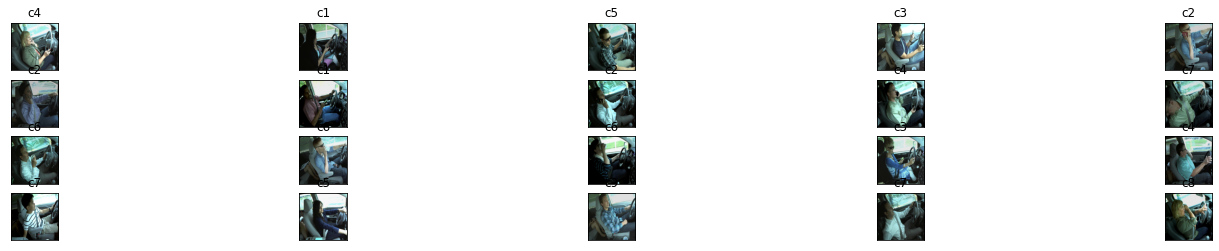

In [11]:
# plotting sample images
dataiter = iter(training_loader)
images, labels = dataiter.next()
print(len(images))
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

plt.show()

In [5]:
# Defining the model
model = models.vgg16(pretrained=True)
# Freezing the feature parameters
for param in model.features.parameters():
  param.requires_grad = False

# Defining the loss, optimizer and learning rate
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# changing the last layer of VGG16 to have a size of 10
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, 10)
model.classifier[6] = last_layer
model.to(device)
# load previously saved weights
#model.load_state_dict(torch.load(os.path.join(main_directory, '20220302_201239_weights.h5')))
# defining the softmax for converting the output to probabilities
module_softmax = nn.Softmax(dim=1)
#print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/aaronli/.cache/torch/hub/checkpoints/vgg16-397923af.pth
4.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

12.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

21.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_ms

In [6]:
# training the model
epochs = 20
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    else:
        epoch_loss = running_loss / len(training_loader.dataset)
        epoch_acc = running_corrects.float() / len(training_loader.dataset)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
        print('epoch :', (e + 1))
        print('training loss: {:.4f}, acc {:.4f}, num of corrects {} '.format(epoch_loss, epoch_acc.item(), running_corrects))

# saving the weights
file_date = datetime.now().strftime("%Y%m%d_%H%M%S")
torch.save(model.state_dict(), os.path.join(main_directory, file_date + '_weights.h5'))

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
plt.plot(running_loss_history, label='training loss')
plt.legend()
plt.show()

# plotting a sample of 9 images and their predicted action
for indx in range(9):
    rand_img = random.choice(os.listdir(test_directory))
    img = Image.open(os.path.join(test_directory, rand_img))
    plt.subplot(3, 3, indx + 1)
    plt.axis('off')
    plt.imshow(img)
    img = transform_test(img)
    #plt.imshow(im_convert(img))
    image = img.to(device).unsqueeze(0)
    output = model(image)
    _, pred = torch.max(output, 1)
    out_soft = module_softmax(output)
    #print(classes[pred.item()])
    #print(action[pred.item()])
    plt.title('{},{:.2f}'.format(action[pred.item()], torch.max(out_soft)))
    #time.sleep(1)
plt.show()

In [ ]:
# generating the output file
file_result = os.path.join(main_directory, 'submit_result_v1.csv')
with open(file_result, 'w') as csvfile:
    #csvwriter = csv.writer(csvfile)
    for img_file in os.listdir(test_directory):
        img = Image.open(os.path.join(test_directory, img_file))
        img = transform_test(img)
        image = img.to(device).unsqueeze(0)
        output = model(image)
        out_soft = module_softmax(output)
        #_, pred = torch.max(output, 1)
        out_np = out_soft[0].detach().cpu().numpy().reshape(1, 10)
        #onerow = '{}, {}'.format(img_file, out_np)
        onerow = img_file + ','
        csvfile.write(onerow)
        np.savetxt(csvfile, out_np, fmt='%1.2f', delimiter=',')